<a href="https://colab.research.google.com/github/chrisliii/FINE-452/blob/main/M%26A_CAPM_FF3_Daily_MultiStocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Modules

In [1]:
!pip install yfinance

import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm
import matplotlib.pyplot as plt

     |████████████████████████████████| 5.5MB 3.9MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22618 sha256=714a6b3fae91a10bb293c462871b331b2a0b96ff10019b7b6c7e463465cf9d2c
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Data Prep

In [12]:
#S&P500 - ^GSPC
stock_name = "STZ"
ticker = yf.Ticker(stock_name)
#ticker.info
# daily data
df_ticker_daily_return = ticker.history(period="max", interval='1d')
# process Dividends
df_ticker_daily_return = df_ticker_daily_return.dropna(how='all')
# daily return
#df_ticker_daily_return['DailyReturn'] = 100*( (df_ticker_daily_return['Close']+df_ticker_daily_return['Dividends']).div(df_ticker_daily_return['Open']) - 1)
df_ticker_daily_return['DailyReturn'] = 100*( (df_ticker_daily_return['Close']+df_ticker_daily_return['Dividends']).div(df_ticker_daily_return['Close'].shift(1)) - 1)
df_ticker_daily_return = df_ticker_daily_return.dropna()
#date to string
df_ticker_daily_return = df_ticker_daily_return.reset_index()
df_ticker_daily_return['Date'] = df_ticker_daily_return['Date'].apply(lambda x: x.strftime('%Y%m%d'))

df_ticker_daily_return.head(5)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,DailyReturn
0,19920318,1.452155,1.490880,1.442474,1.490880,617600,0.0,0.0,4.054067
1,19920319,1.510241,1.529604,1.490879,1.519922,984000,0.0,0.0,1.948042
2,19920320,1.500560,1.539285,1.500560,1.539285,260000,0.0,0.0,1.273887
3,19920323,1.548965,1.578009,1.548965,1.548965,658400,0.0,0.0,0.628920
4,19920324,1.548965,1.616732,1.548965,1.587689,230400,0.0,0.0,2.499988


In [5]:
df_FF_Research = pd.read_csv('F-F_Research_Data_Factors_daily.CSV', encoding="utf-8", skipinitialspace=True, skiprows=4)
df_FF_Research.columns = ['Date', 'Mkt-RF', 'SMB', 'HML', 'RF']
df_FF_Research = df_FF_Research.dropna()

#df_FF_Research['Date'] = df_FF_Research['Date'].shift(1)
#df_FF_Research['RF'] = df_FF_Research['RF'].shift(1)
#df_FF_Research = df_FF_Research.dropna()

df_FF_Research['RF'] = df_FF_Research['RF'].astype(float)
df_FF_Research['Mkt-RF'] = df_FF_Research['Mkt-RF'].astype(float)
df_FF_Research['SMB'] = df_FF_Research['SMB'].astype(float)
df_FF_Research['HML'] = df_FF_Research['HML'].astype(float)

df_FF_Research.head()

,Date,Mkt-RF,SMB,HML,RF
0,19260701,0.10,-0.24,-0.28,0.009
1,19260702,0.45,-0.32,-0.08,0.009
2,19260706,0.17,0.27,-0.35,0.009
3,19260707,0.09,-0.59,0.03,0.009
4,19260708,0.21,-0.36,0.15,0.009


### CAPM

#### CAPM Rolling Regression

In [ ]:
# past period rolling

# data prep
df_ticker_FF = pd.merge(df_ticker_daily_return, df_FF_Research, on='Date')
df_ticker_FF['Date'] = pd.to_datetime(df_ticker_FF['Date'], format='%Y%m%d')

# sample period
begin_date = datetime(2010, 10, 1)
end_date = datetime(2020, 9, 1)
#in days
sample_period = 1080

# CAPM out of sample
for sample_date in df_ticker_FF[df_ticker_FF.Date >= begin_date].Date.tolist():
  df_ticker_FF_sample = df_ticker_FF[(df_ticker_FF.Date >= (sample_date - timedelta(days=sample_period)) ) & 
                                     (df_ticker_FF.Date < sample_date)].copy()
  CAPM_model = sm.OLS(df_ticker_FF_sample['DailyReturn'], sm.add_constant(df_ticker_FF_sample[['Mkt-RF']].values))
  CAPM_result = CAPM_model.fit()
  #print(stock_name + '\n')
  #print (result.params)
  #print(CAPM_result.summary())

  # predict 
  sample_input = df_ticker_FF[(df_ticker_FF.Date == sample_date)]
  sample_input = sample_input['Mkt-RF'].values[0]
  sample_pred =  CAPM_result.predict([1,sample_input])
  #print(sample_input)
  #print(sample_pred)
  df_ticker_FF.loc[df_ticker_FF.Date == sample_date, 'PredReturn'] = sample_pred[0]


df_ticker_FF = df_ticker_FF.dropna()

df_ticker_FF.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,DailyReturn,Mkt-RF,SMB,HML,RF,PredReturn
316,2010-10-01,44.969887,45.007938,44.216455,44.642639,606700,0.0,0,-0.727704,0.43,-0.06,0.21,0.001,0.377779
317,2010-10-04,43.912042,44.231678,43.615237,43.828327,575300,0.0,0,-0.190642,-0.88,-0.73,-0.04,0.001,-0.323757
318,2010-10-05,44.505658,45.228647,44.490437,45.129711,1171200,0.0,0,1.402188,2.11,0.77,0.16,0.001,1.268695
319,2010-10-06,45.342792,45.662427,45.091647,45.578712,639500,0.0,0,0.520305,-0.10,-0.39,0.43,0.001,0.092483
320,2010-10-07,45.692881,45.723324,44.992723,45.289528,1785300,0.0,0,-0.882749,-0.16,0.05,-0.27,0.001,0.061887


#### CAPM Cumulative Regression Function

In [6]:
# past period accumulative

def CAPMCumulativeRegression(stock_name, begin_date):
  #stock data
  ticker = yf.Ticker(stock_name)
  #ticker.info
  # daily data
  df_ticker_daily_return = ticker.history(period="max", interval='1d')
  # process Dividends
  df_ticker_daily_return = df_ticker_daily_return.dropna(how='all')
  # daily return
  #df_ticker_daily_return['DailyReturn'] = 100*( (df_ticker_daily_return['Close']+df_ticker_daily_return['Dividends']).div(df_ticker_daily_return['Open']) - 1)
  df_ticker_daily_return['DailyReturn'] = 100*( (df_ticker_daily_return['Close']+df_ticker_daily_return['Dividends']).div(df_ticker_daily_return['Close'].shift(1)) - 1)
  df_ticker_daily_return = df_ticker_daily_return.dropna()
  #date to string
  df_ticker_daily_return = df_ticker_daily_return.reset_index()
  df_ticker_daily_return['Date'] = df_ticker_daily_return['Date'].apply(lambda x: x.strftime('%Y%m%d'))
  # data prep
  df_ticker_FF = pd.merge(df_ticker_daily_return, df_FF_Research, on='Date')
  df_ticker_FF['Date'] = pd.to_datetime(df_ticker_FF['Date'], format='%Y%m%d')

  # sample period
  #begin_date = datetime(2010, 10, 1)
  end_date = datetime(2020, 7, 1)
  # in days
  sample_period = 1825

  # CAPM out of sample
  for sample_date in df_ticker_FF[df_ticker_FF.Date >= begin_date].Date.tolist():
    df_ticker_FF_sample = df_ticker_FF[(df_ticker_FF.Date >= (begin_date - timedelta(days=sample_period)) ) & 
                                      (df_ticker_FF.Date < sample_date)].copy()
    CAPM_model = sm.OLS(df_ticker_FF_sample['DailyReturn'], sm.add_constant(df_ticker_FF_sample[['Mkt-RF']].values))
    CAPM_result = CAPM_model.fit()
    #print(stock_name + '\n')
    #print (result.params)
    #print(CAPM_result.summary())

    # predict 
    sample_input = df_ticker_FF[(df_ticker_FF.Date == sample_date)]
    sample_input = sample_input['Mkt-RF'].values[0]
    sample_pred =  CAPM_result.predict([1,sample_input])
    #print(sample_input)
    #print(sample_pred)
    df_ticker_FF.loc[df_ticker_FF.Date == sample_date, 'PredReturn'] = sample_pred[0]

  df_ticker_FF = df_ticker_FF.dropna()

  # Epsilon
  df_ticker_FF['Epsilon'] = df_ticker_FF.DailyReturn - df_ticker_FF.RF - df_ticker_FF.PredReturn
  # RollingSumEpsilon
  df_ticker_FF['RollingSumEpsilon'] = df_ticker_FF.Epsilon.rolling(30).sum()
  # CumSumEpsilon
  for date in df_ticker_FF[df_ticker_FF.Date >= begin_date + relativedelta(months=12)].Date.tolist():
    df_ticker_FF.loc[df_ticker_FF.Date == date, 'CumSumEpsilon'] = df_ticker_FF[df_ticker_FF.Date <= date].Epsilon.sum()
  # AbsEpsilon
  df_ticker_FF['AbsEpsilon'] = abs(df_ticker_FF['Epsilon'])
  # RollingAvgAbsEpsilon
  df_ticker_FF['RollingAvgAbsEpsilon'] = df_ticker_FF.AbsEpsilon.rolling(30).mean()
  # CumAvgAbsEpsilon
  for date in df_ticker_FF[df_ticker_FF.Date >= begin_date + relativedelta(months=12)].Date.tolist():
    df_ticker_FF.loc[df_ticker_FF.Date == date, 'CumAvgAbsEpsilon'] = df_ticker_FF[df_ticker_FF.Date <= date].AbsEpsilon.mean()

  df_ticker_FF = df_ticker_FF.dropna()

  return df_ticker_FF

#### CAPM Epsilon

#### CAPM Plot 6 subplots

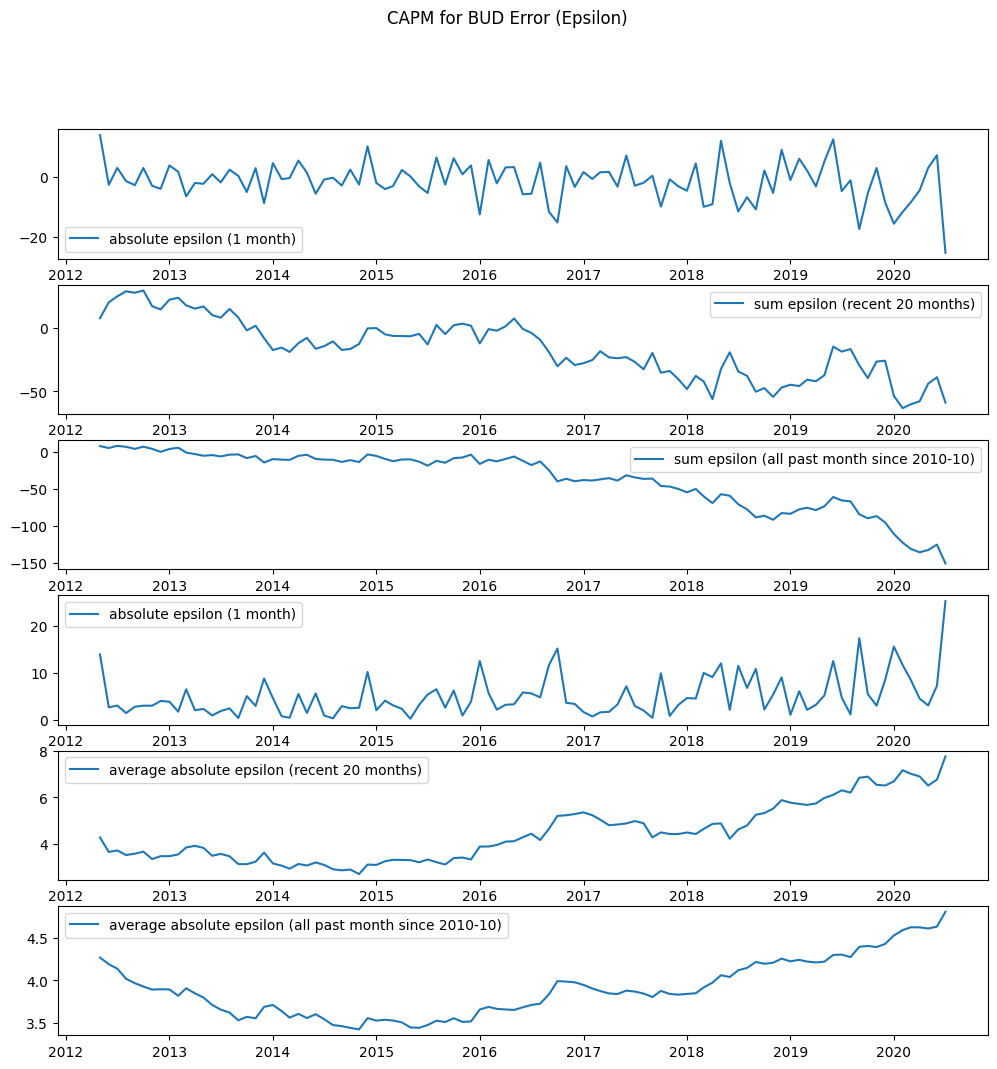

In [ ]:
df_ticker_FF = df_ticker_FF.dropna()

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, dpi=100, figsize=(12,12))
fig.suptitle('CAPM for '+ stock_name +' Error (Epsilon)')
ax1.plot(df_ticker_FF.Date, df_ticker_FF.Epsilon, label='absolute epsilon (1 month)')
ax1.legend()
ax2.plot(df_ticker_FF.Date, df_ticker_FF.RollingSumEpsilon, label='sum epsilon (recent 20 months)')
ax2.legend()
ax3.plot(df_ticker_FF.Date, df_ticker_FF.CumSumEpsilon, label='sum epsilon (all past month since 2010-10)')
ax3.legend()
ax4.plot(df_ticker_FF.Date, df_ticker_FF.AbsEpsilon, label='absolute epsilon (1 month)')
ax4.legend()
ax5.plot(df_ticker_FF.Date, df_ticker_FF.RollingAvgAbsEpsilon, label='average absolute epsilon (recent 20 months)')
ax5.legend()
ax6.plot(df_ticker_FF.Date, df_ticker_FF.CumAvgAbsEpsilon, label='average absolute epsilon (all past month since 2010-10)')
ax6.legend()

#### CAPM Plot 3 subplots

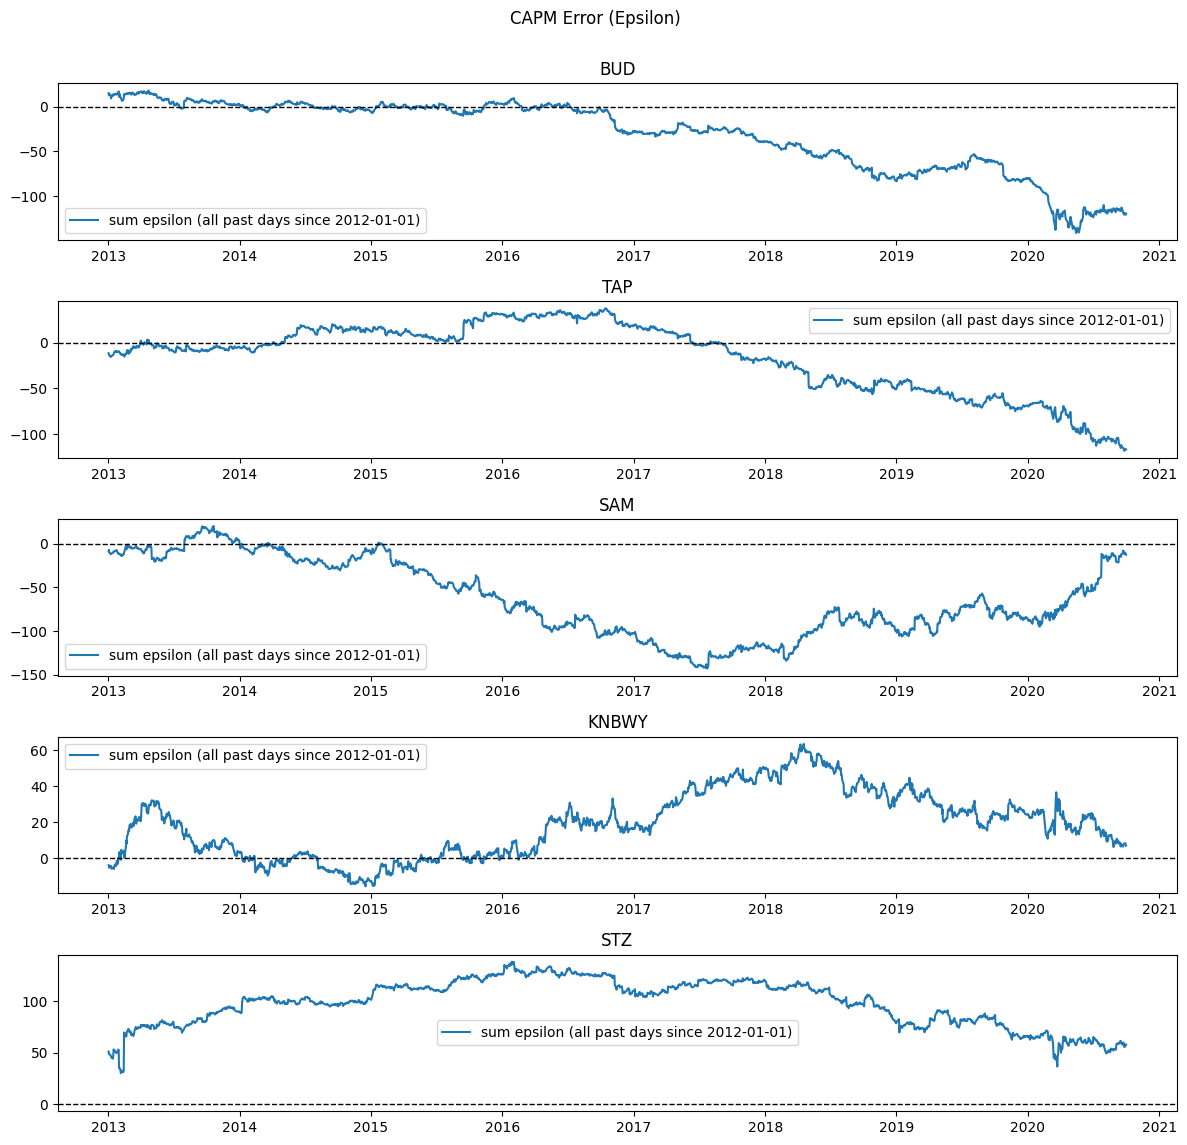

In [19]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, dpi=100, figsize=(12,12))
fig.suptitle('CAPM Error (Epsilon)')

begin_date = datetime(2012, 1, 1)
begin_date_label = '2012-01-01'

#BUD
df_ticker_FF = CAPMCumulativeRegression('BUD', begin_date)
ax1.plot(df_ticker_FF.Date, df_ticker_FF.CumSumEpsilon, label='sum epsilon (all past days since {})'.format(begin_date_label))
ax1.axhline(y=0, linewidth=1, color='black', linestyle='--')
ax1.title.set_text('BUD')
ax1.legend()

#TAP
df_ticker_FF = CAPMCumulativeRegression('TAP', begin_date)
ax2.plot(df_ticker_FF.Date, df_ticker_FF.CumSumEpsilon, label='sum epsilon (all past days since {})'.format(begin_date_label))
ax2.axhline(y=0, linewidth=1, color='black', linestyle='--')
ax2.title.set_text('TAP')
ax2.legend()

#SAM
df_ticker_FF = CAPMCumulativeRegression('SAM', begin_date)
ax3.plot(df_ticker_FF.Date, df_ticker_FF.CumSumEpsilon, label='sum epsilon (all past days since {})'.format(begin_date_label))
ax3.axhline(y=0, linewidth=1, color='black', linestyle='--')
ax3.title.set_text('SAM')
ax3.legend()

#KNBWY
df_ticker_FF = CAPMCumulativeRegression('KNBWY', begin_date)
ax4.plot(df_ticker_FF.Date, df_ticker_FF.CumSumEpsilon, label='sum epsilon (all past days since {})'.format(begin_date_label))
ax4.axhline(y=0, linewidth=1, color='black', linestyle='--')
ax4.title.set_text('KNBWY')
ax4.legend()

#STZ
df_ticker_FF = CAPMCumulativeRegression('STZ', begin_date)
ax5.plot(df_ticker_FF.Date, df_ticker_FF.CumSumEpsilon, label='sum epsilon (all past days since {})'.format(begin_date_label))
ax5.axhline(y=0, linewidth=1, color='black', linestyle='--')
ax5.title.set_text('STZ')
ax5.legend()

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

### FF3

#### FF3 Cumulative Regression

In [20]:
# past period accumulative

def FF3CumulativeRegression(stock_name, begin_date):
  #stock data
  ticker = yf.Ticker(stock_name)
  #ticker.info
  # daily data
  df_ticker_daily_return = ticker.history(period="max", interval='1d')
  # process Dividends
  df_ticker_daily_return = df_ticker_daily_return.dropna(how='all')
  # daily return
  #df_ticker_daily_return['DailyReturn'] = 100*( (df_ticker_daily_return['Close']+df_ticker_daily_return['Dividends']).div(df_ticker_daily_return['Open']) - 1)
  df_ticker_daily_return['DailyReturn'] = 100*( (df_ticker_daily_return['Close']+df_ticker_daily_return['Dividends']).div(df_ticker_daily_return['Close'].shift(1)) - 1)
  df_ticker_daily_return = df_ticker_daily_return.dropna()
  #date to string
  df_ticker_daily_return = df_ticker_daily_return.reset_index()
  df_ticker_daily_return['Date'] = df_ticker_daily_return['Date'].apply(lambda x: x.strftime('%Y%m%d'))
  # data prep
  df_ticker_FF = pd.merge(df_ticker_daily_return, df_FF_Research, on='Date')
  df_ticker_FF['Date'] = pd.to_datetime(df_ticker_FF['Date'], format='%Y%m%d')

  # sample period
  #begin_date = datetime(2010, 10, 1)
  end_date = datetime(2020, 7, 1)
  # in days
  sample_period = 1825

  # FF3 out of sample
  sample_date = begin_date
  for sample_date in df_ticker_FF[df_ticker_FF.Date >= begin_date].Date.tolist():
    df_ticker_FF_sample = df_ticker_FF[(df_ticker_FF.Date >= (begin_date - timedelta(days=sample_period)) ) & 
                                      (df_ticker_FF.Date < sample_date)].copy()
    FF3_model = sm.OLS(df_ticker_FF_sample['DailyReturn'], 
                        sm.add_constant(df_ticker_FF_sample[['Mkt-RF', 'SMB', 'HML']].values))
    FF3_result = FF3_model.fit()
    #print(stock_name + '\n')
    #print (FF3_result.params)
    #print(FF3_result.summary())

    # predict 
    sample_input = df_ticker_FF[(df_ticker_FF.Date == sample_date)]
    sample_input = sample_input[['Mkt-RF', 'SMB', 'HML']].values[0].tolist()
    sample_pred =  FF3_result.predict([1] + sample_input)
    #print(sample_input)
    #print(sample_pred)
    df_ticker_FF.loc[df_ticker_FF.Date == sample_date, 'PredReturn'] = sample_pred[0]


  # Epsilon
  df_ticker_FF['Epsilon'] = df_ticker_FF.DailyReturn - df_ticker_FF.RF - df_ticker_FF.PredReturn
  # RollingSumEpsilon
  df_ticker_FF['RollingSumEpsilon'] = df_ticker_FF.Epsilon.rolling(30).sum()
  # CumSumEpsilon
  for date in df_ticker_FF[df_ticker_FF.Date >= begin_date + relativedelta(months=12)].Date.tolist():
    df_ticker_FF.loc[df_ticker_FF.Date == date, 'CumSumEpsilon'] = df_ticker_FF[df_ticker_FF.Date <= date].Epsilon.sum()
  # AbsEpsilon
  df_ticker_FF['AbsEpsilon'] = abs(df_ticker_FF['Epsilon'])
  # RollingAvgAbsEpsilon
  df_ticker_FF['RollingAvgAbsEpsilon'] = df_ticker_FF.AbsEpsilon.rolling(30).mean()
  # CumAvgAbsEpsilon
  for date in df_ticker_FF[df_ticker_FF.Date >= begin_date + relativedelta(months=12)].Date.tolist():
    df_ticker_FF.loc[df_ticker_FF.Date == date, 'CumAvgAbsEpsilon'] = df_ticker_FF[df_ticker_FF.Date <= date].AbsEpsilon.mean()

  df_ticker_FF = df_ticker_FF.dropna()

  return df_ticker_FF

#### FF3 Epsilon

#### FF3 Plot 6 subplots

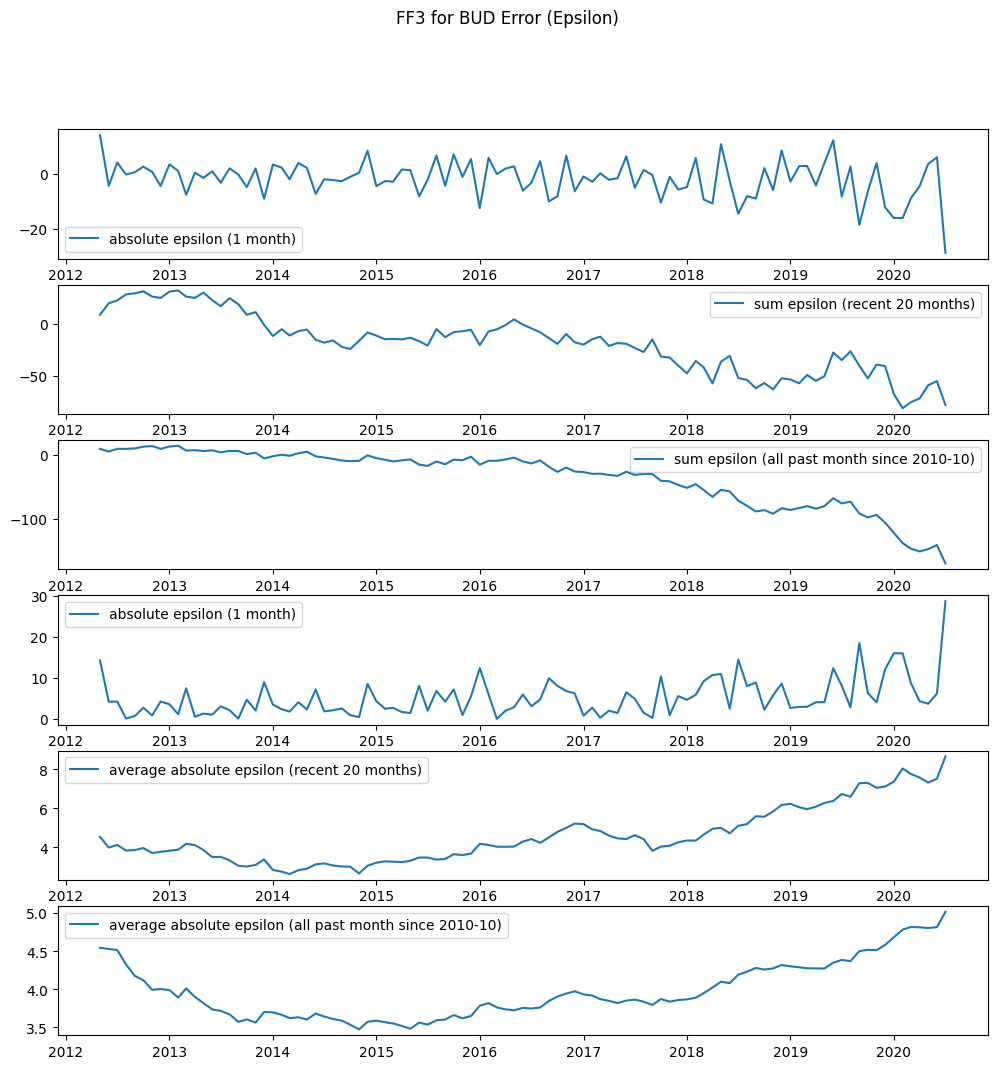

In [ ]:
df_ticker_FF = df_ticker_FF.dropna()

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, dpi=100, figsize=(12,12))
fig.suptitle('FF3 for '+ stock_name +' Error (Epsilon)')
ax1.plot(df_ticker_FF.Date, df_ticker_FF.Epsilon, label='absolute epsilon (1 month)')
ax1.legend()
ax2.plot(df_ticker_FF.Date, df_ticker_FF.RollingSumEpsilon, label='sum epsilon (recent 20 months)')
ax2.legend()
ax3.plot(df_ticker_FF.Date, df_ticker_FF.CumSumEpsilon, label='sum epsilon (all past month since 2010-10)')
ax3.legend()
ax4.plot(df_ticker_FF.Date, df_ticker_FF.AbsEpsilon, label='absolute epsilon (1 month)')
ax4.legend()
ax5.plot(df_ticker_FF.Date, df_ticker_FF.RollingAvgAbsEpsilon, label='average absolute epsilon (recent 20 months)')
ax5.legend()
ax6.plot(df_ticker_FF.Date, df_ticker_FF.CumAvgAbsEpsilon, label='average absolute epsilon (all past month since 2010-10)')
ax6.legend()

#### FF3 Plot 3 subplots

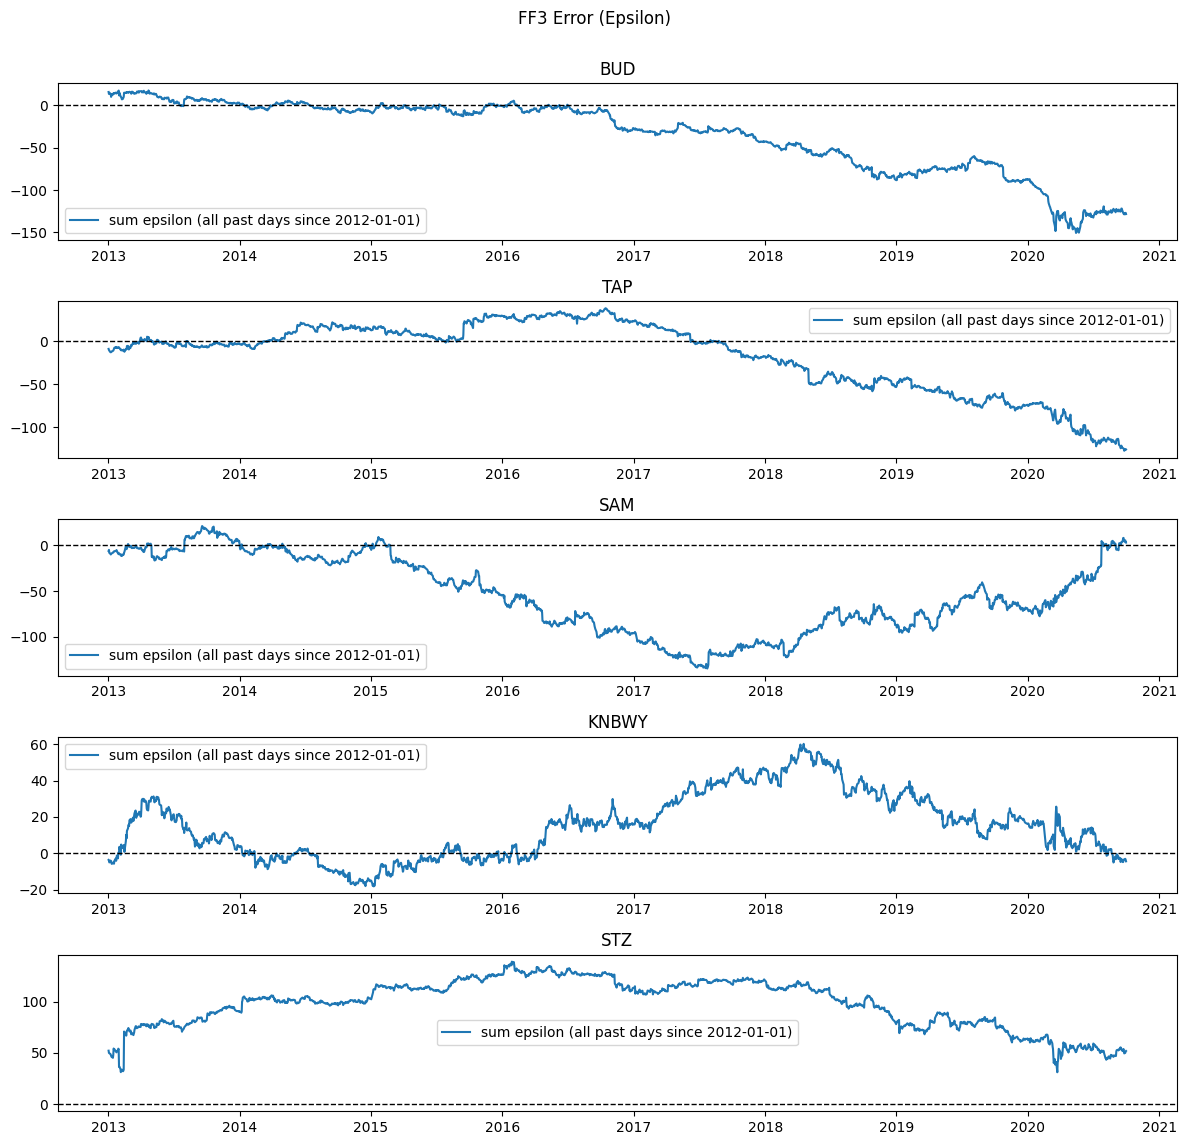

In [21]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, dpi=100, figsize=(12,12))
fig.suptitle('FF3 Error (Epsilon)')

begin_date = datetime(2012, 1, 1)
begin_date_label = '2012-01-01'

#BUD
df_ticker_FF = FF3CumulativeRegression('BUD', begin_date)
ax1.plot(df_ticker_FF.Date, df_ticker_FF.CumSumEpsilon, label='sum epsilon (all past days since {})'.format(begin_date_label))
ax1.axhline(y=0, linewidth=1, color='black', linestyle='--')
ax1.title.set_text('BUD')
ax1.legend()

#TAP
df_ticker_FF = FF3CumulativeRegression('TAP', begin_date)
ax2.plot(df_ticker_FF.Date, df_ticker_FF.CumSumEpsilon, label='sum epsilon (all past days since {})'.format(begin_date_label))
ax2.axhline(y=0, linewidth=1, color='black', linestyle='--')
ax2.title.set_text('TAP')
ax2.legend()

#SAM
df_ticker_FF = FF3CumulativeRegression('SAM', begin_date)
ax3.plot(df_ticker_FF.Date, df_ticker_FF.CumSumEpsilon, label='sum epsilon (all past days since {})'.format(begin_date_label))
ax3.axhline(y=0, linewidth=1, color='black', linestyle='--')
ax3.title.set_text('SAM')
ax3.legend()

#KNBWY
df_ticker_FF = FF3CumulativeRegression('KNBWY', begin_date)
ax4.plot(df_ticker_FF.Date, df_ticker_FF.CumSumEpsilon, label='sum epsilon (all past days since {})'.format(begin_date_label))
ax4.axhline(y=0, linewidth=1, color='black', linestyle='--')
ax4.title.set_text('KNBWY')
ax4.legend()

#STZ
df_ticker_FF = FF3CumulativeRegression('STZ', begin_date)
ax5.plot(df_ticker_FF.Date, df_ticker_FF.CumSumEpsilon, label='sum epsilon (all past days since {})'.format(begin_date_label))
ax5.axhline(y=0, linewidth=1, color='black', linestyle='--')
ax5.title.set_text('STZ')
ax5.legend()

fig.tight_layout(rect=[0, 0.03, 1, 0.95])